In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/jhernandez/Work//python_tools')
import tools
import os
from glob import glob

In [2]:
import sys
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import parcels
from parcels import FieldSet, ParticleSet, Variable, JITParticle,ScipyParticle,Field, AdvectionRK4_3D, AdvectionRK4,BrownianMotion2D, OutOfBoundsError,  KernelError,plotTrajectoriesFile,random

In [5]:

from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4, plotTrajectoriesFile
import numpy as np
import math
from datetime import timedelta, datetime
from operator import attrgetter

### Launch Parcels particles for HFR DIVAnd reconstructed field

    - For Oct 2014, in coincidence with DA experiments, use HFR DIVAnd fields
    - Launch particles and evaluate in comparison to WMOP DA 
    - Use drifters as well for validation

In [6]:
from advection_diffusion import *

#### Drifters files

In [7]:
files_drifters = glob('/home/jhernandez/Escritorio/Drifters/10_2014/files/*')
files_drifters.sort()

##### Some particle parameters

In [5]:
particles_n = 50
dt = timedelta(minutes=30)
integration_time = timedelta(hours=24*3)
output_dt = timedelta(minutes=60)
ND = 1000


#### Function: generate_initial_position_particles

In [9]:
def generate_initial_position_particles(lons, lats, ND, diffussion=True):
    
    if diffussion == True:
        # Create arrays for initial position particles
        lon0 = np.repeat(lons,ND)
        lat0 = np.repeat(lats,ND)
        
    else:
        inc_mag=0.01
        lat0 = []
        lon0 = []
        for i in range(len(lats)):
            lat = [lats[i]-(np.random.rand()*inc_mag) for n in range(ND)]
            lon = [lons[i]+(np.random.rand()*inc_mag) for n in range(ND)]
            lat0 = lat0 + lat
            lon0 = lon0 + lon
        lat0 = np.array(lat0)
        lon0 = np.array(lon0)
            
    depths = lat0*0
    
    return lon0, lat0, depths

##### Create new particle class

In [10]:
class PlasticParticle(JITParticle):
    age = Variable('age', dtype=np.float32, initial=0.)
    # beached : 0 sea, 1 beached, 2 after non-beach dyn, 3 after beach dyn, 4 please unbeach
    beached = Variable('beached', dtype=np.int32, initial=0.)
    unbeachCount = Variable('unbeachCount', dtype=np.int32, initial=0.)
    
def DeleteParticle(particle, fieldset, time):
    particle.delete()

#### Example (by Laura Navarro)
    Execute particle Set and eliminate any particle OutofBounds

In [ ]:
#pset_AZO_grid_v2.execute(AdvectionRK4, runtime=timedelta(days=7.), dt=timedelta(minutes=5),
 #            recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle}, output_file=output_file)

### Get HFR DIVAnd fields

In [8]:
file_diva = '/home/jhernandez/Work/data/SDC_IBIZACHANNEL_HFRadar_DP1.nc'
ds_hfr = xr.open_dataset(file_diva)

In [9]:
def prepare_diva_field(ds):
    """ Extend lon, lat in order to put a frame of NaN values,
    so particles beach when get out of the domain """
    
    lon = ds.lon.values
    lat = ds.lat.values

    lon_diff = np.diff(lon)[0]
    lat_diff = np.diff(lat)[0]

    lon = np.append(lon, [lon[-1] + lon_diff, lon[-1] + 2*lon_diff])
    lon = np.append([lon[0] - 2*lon_diff, lon[0] - lon_diff], lon)

    lat = np.append(lat, [lat[-1] + lat_diff, lat[-1] + 2*lat_diff])
    lat = np.append([lat[0] - 2*lat_diff, lat[0] - lat_diff], lat)

    nz, ny, nx = ds.u.shape
    u = np.empty((nz, ny+4, nx+4))
    u[:] = np.nan
    v = np.empty((nz, ny+4, nx+4))
    v[:]= np.nan

    u[:,2:-2,2:-2] = ds.u.values
    v[:,2:-2,2:-2] = ds.v.values
    
    return lon, lat, u, v
    

## Launch Simulation

- 3 days lagrangian simulation
- WMOP ASSIM his fields are used from waverider
- Each day 2000 particles launched. 1000 at the position of the drifter at 00:00 the initial date
- kernels for AdvectionRK4, Brownian 2D and Beaching included

In [10]:
import time

#### Simulate particles

In [14]:
date = datetime(2014,10,1)
ndays=5

for i in range(8):

    print(date)
    t0_field = time.time()

    strdate_ini = date.strftime('%Y%m%d')
    strdate_end = (date + timedelta(days=ndays) ).strftime('%Y%m%d')

    ds_sel = ds_hfr.sel(time=slice(strdate_ini, strdate_end))
    times = ds_sel.time.values.astype(datetime)/10**9

    lon, lat, u, v = prepare_diva_field(ds_sel)

    fieldset = FieldSet.from_data(
        {'U':u,'V':v},
        {'U':{'lon':lon,'lat':lat,'time': times},
         'V':{'lon':lon,'lat':lat,'time': times}} )

    # diffussion parameters
    kh_zonal = 20 # in m^2/s
    kh_meridional = 20  # in m^2/s

    # Create field of Kh_zonal and Kh_meridional, using same grid as U
    grid = fieldset.U.grid
    fieldset.add_field(Field('Kh_zonal', kh_zonal*np.ones(u.shape), grid=grid))
    fieldset.add_field(Field('Kh_meridional', kh_zonal*np.ones(u.shape), grid=grid))

    # Get Initial position of particles
    lons = []
    lats = []

    for file in files_drifters:
        ds_drif = xr.open_dataset(file)
        ds_drif = ds_drif.sel(time=date.strftime('%Y-%m-%d'))

        if ds_drif.time.shape[0] == 0:
            print(F"No time close to target for Drifer:  {file.split('/')[-1]}")
        else:
            lons.append( ds_drif.LON.values[0])
            lats.append( ds_drif.LAT.values[0])

    # Create arrays for initial position particles
    lon0, lat0, depths = generate_initial_position_particles(lons, lats, ND, diffussion=True)

    # Extract points outside domain
    ii = (lon0>lon.max()) | (lon0<lon.min() ) | (lat0>lat.max() ) | (lat0<lat.min() )
    lon0 = lon0[~ii]
    lat0 = lat0[~ii]
    depths = depths[~ii]
                  
    pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=PlasticParticle,  # the type of particles (JITParticle or ScipyParticle)
                             #time=release_time,
                             lon=lon0, # a vector of release longitudes 
                             lat=lat0,
                             depth=depths)

    #runtime = (end_date - start_date).as_timedelta()
    runtime = timedelta(days=5)

    kernel =  pset.Kernel(AdvectionRK42) + pset.Kernel(BeachTesting_2D) + pset.Kernel(BrownianMotion2D2) + pset.Kernel(BeachTesting_2D)

    output_path = F"/home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields/"

    if os.path.isdir(output_path)==False:
        os.system(F"mkdir /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields/")

    output_name = F"{output_path}/wmop_advection_{strdate_ini}_{strdate_end}.nc"

    # Execute lagrangian particle simulation  

    pset.execute( kernel,runtime=runtime, dt=dt,
                 output_file=pset.ParticleFile(name=output_name, outputdt=output_dt))


    tf_field = time.time()

    print(F"Time spent to load Fieldset for {ndays} days = {tf_field-t0_field} seconds")

    date = date + timedelta(days=1)


2014-10-01 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2DBrownianMotion2D2BeachTesting_2D ==> /tmp/parcels-22478/b0b6b88d5c5fe847c8cc3ee3f67a584e_0.so
INFO: Temporary output files are stored in /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields/out-LGKLEEFB.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields/out-LGKLEEFB" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:34 Time:  0:01:34


Time spent to load Fieldset for 5 days = 116.374342918396 seconds
2014-10-02 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2DBrownianMotion2D2BeachTesting_2D ==> /tmp/parcels-22478/202780c3a7ca45b8193484c8bd6ad204_0.so
INFO: Temporary output files are stored in /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields/out-TZOVNUGX.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields/out-TZOVNUGX" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:34 Time:  0:01:34


Time spent to load Fieldset for 5 days = 120.35095524787903 seconds
2014-10-03 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2DBrownianMotion2D2BeachTesting_2D ==> /tmp/parcels-22478/208021210e4a7f81ca68d460f3837e97_0.so
INFO: Temporary output files are stored in /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields/out-RDBNPAWQ.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields/out-RDBNPAWQ" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:33 Time:  0:01:33


Time spent to load Fieldset for 5 days = 120.52873802185059 seconds
2014-10-04 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2DBrownianMotion2D2BeachTesting_2D ==> /tmp/parcels-22478/461bd26990828ee04948614c4b7abbdc_0.so
INFO: Temporary output files are stored in /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields/out-FROPLZUT.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields/out-FROPLZUT" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:32 Time:  0:01:32


Time spent to load Fieldset for 5 days = 119.5089943408966 seconds
2014-10-05 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2DBrownianMotion2D2BeachTesting_2D ==> /tmp/parcels-22478/870996da516407a4cbbeea343cbcf2c4_0.so
INFO: Temporary output files are stored in /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields/out-ZHCPUDEK.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields/out-ZHCPUDEK" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:33 Time:  0:01:33


Time spent to load Fieldset for 5 days = 119.94424223899841 seconds
2014-10-06 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2DBrownianMotion2D2BeachTesting_2D ==> /tmp/parcels-22478/85da4f197e94517c583fe0dc9cc64a57_0.so
INFO: Temporary output files are stored in /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields/out-SJAJIGZP.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields/out-SJAJIGZP" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:33 Time:  0:01:33


Time spent to load Fieldset for 5 days = 121.03272080421448 seconds
2014-10-07 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2DBrownianMotion2D2BeachTesting_2D ==> /tmp/parcels-22478/91fee42e65909ba113b79471a1ba3cb1_0.so
INFO: Temporary output files are stored in /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields/out-EXIPZMUT.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields/out-EXIPZMUT" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:24 Time:  0:01:24


Time spent to load Fieldset for 5 days = 110.38662266731262 seconds
2014-10-08 00:00:00


INFO: Compiled PlasticParticleAdvectionRK42BeachTesting_2DBrownianMotion2D2BeachTesting_2D ==> /tmp/parcels-22478/5560fadbd407ab7bce6b86e43bf8e97e_0.so
INFO: Temporary output files are stored in /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields/out-MGYYEYQA.
INFO: You can use "parcels_convert_npydir_to_netcdf /home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields/out-MGYYEYQA" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:01:05 Time:  0:01:05


Time spent to load Fieldset for 5 days = 90.16102838516235 seconds


In [7]:
files = glob('/home/jhernandez/Work/trajectories/trajectories_HFR_DA/DIVAnd-fields/*nc')
files.sort()
for f in files:
    ds = xr.open_dataset(f)
    print(ds.lon.shape)

(14000, 121)
(14000, 121)
(14000, 121)
(14000, 121)
(14000, 121)
(14000, 121)
(13000, 121)
(11000, 121)


In [11]:
# Select experiments
def select_experiments(subset, experiment_list):
    """Give a list of positions within the experiment list dictionary"""
    
    exp_list = [exp for i,exp in enumerate(experiment_list) if i in subset];  
    colors = [experiment_list[exp][1] for i,exp in enumerate(experiment_list) if i in subset]; 
    labels = [experiment_list[exp][2] for i,exp in enumerate(experiment_list) if i in subset]; 
    
    print(F' Selected experiments: {exp_list}')
    
    return exp_list, colors, labels

#### Experiments List

In [14]:
experiment_list = {'CR': ['HFR_NOASSIM_Oct2014', 'black', 'CR'], 
            'GNR': ['HFR_generic_nonudging_Oct2014_v2', 'darkblue', 'GNR'],
            'Tot': ['HFR_all_nonudging_Oct2014_v3', 'darkgreen', 'Tot'],
            'R-Raw': ['HFR_radials_raw_nonudging_Oct2014', 'darkred', 'R-Raw'],     
            'DIVA': ['DIVAnd-fields', 'fuchsia', 'DIVA'],
            'R-In': ['HFR_radials_inside_nonudging_Oct2014', 'gold', 'R-In']
                  }
experiment_list = {'CR': ['HFR_NOASSIM_Oct2014', 'black', 'CR'], 
            'GNR': ['HFR_generic_nonudging_Oct2014_v2', 'dodgerblue', 'GNR'],
            'GNR-N': ['HFR_generic_nudging_Oct2014_v2', 'darkblue', 'GNR-N'],
            'Tot': ['HFR_all_nonudging_Oct2014_v3', 'olivedrab', 'Tot'],
          #  'Tot2': ['HFR_totals_nonudging_Oct2014', 'green', 'Tot2'],
            'Tot-N': ['HFR_totals_nudging_Oct2014', 'darkgreen', 'Tot-N'],
            'R-Raw': ['HFR_radials_raw_nonudging_Oct2014', 'salmon', 'R-Raw'],     
            'R-Raw-N': ['HFR_radials_raw_nudging_Oct2014', 'darkred', 'R-Raw-N'],     
            'R-In': ['HFR_radials_inside_nonudging_Oct2014', 'gold', 'R-In'],
            'R-In-N': ['HFR_radials_inside_nudging_Oct2014', 'goldenrod', 'R-In-N'],
            'R-Rep': ['HFR_radials_rep_nonudging_Oct2014', 'darkgrey', 'R-Rep'],
            'R-Rep-N': ['HFR_radials_rep_nudging_Oct2014', 'grey', 'R-Rep-N'],
            'DIVA': ['DIVAnd-fields_v2', 'fuchsia', 'DIVA'],
            'DIVA_Per': ['DIVAnd-fields_persistency', 'violet', 'DIVA-Per'],
            'DIVA_mean': ['DIVAnd-fields_daily-means', 'purple', 'DIVA-Mean']
            
           }



#### Compute Lagrangian Metrics

In [73]:
import seawater as sw

# Drifter files
drifter_files = glob('/home/jhernandez/Escritorio/Drifters/10_2014/files/*nc')
drifter_files.sort()

#experiment_list = ['DIVAnd-fields', 'HFR_radials_raw_Oct2014']#, 'HFR_radial_nonudging_Oct2014_v15', 'HFR_radial_nonudging_Oct2014_v16', 'HFR_radial_nonudging_Oct2014_v17']

dist_mean = {}
dl_cm = {}
dist_all = {}

ndays = 8
ndrif = 13
nt = 121  #ds0.time.shape[1]

# Initialize for inicial position of drifter
lon0 = np.empty((ndrif, ndays)) #* np.nan
lat0 = np.empty((ndrif, ndays)) #* np.nan


## Set limits of DIVA field  --- DISTANCE will only be calculated whithin this area
lonmax_hfr = ds_hfr.lon.max().values
lonmin_hfr = ds_hfr.lon.min().values
latmax_hfr = ds_hfr.lat.max().values
latmin_hfr = ds_hfr.lat.min().values

for exp in experiment_list:

    # Distance travelled by dritfer every hour
    dl_drif = np.empty((ndays, nt-1, ndrif))

    print(exp)

    # Dates
    date_ini = datetime(2014,10,1)

    # Initialize distance matrix
    dist_mean[exp] = np.empty((nt, ndays))
    dl_cm[exp] = np.empty((ndays, nt-1, ndrif))
    dist_all[exp] = np.empty((ndays, nt, ndrif))

    for nday in range(ndays):

        date_end = date_ini + timedelta(days=5)

        strdate = date_ini.strftime('%Y%m%d')
        strdate_end = date_end.strftime('%Y%m%d')
        #print(strdate)

        # Path to virtual particle file
        #folder = F"/home/jhernandez/Work/trajectories/trajectories_HFR_DA/{experiment_list[exp][0]}/"
        folder = F"/LOCALDATA/HFR_DA/trajectories_HFR_DA/{experiment_list[exp][0]}/"
        file_virtual = F"{folder}/wmop_advection_{strdate}_{strdate_end}.nc"

        # Load Virtual particles for selected date
        ds = xr.open_dataset(file_virtual)

        dist_cm = np.empty((nt, ndrif))

        # Time of virtual particle simulations
        tp = ds.time.values
        tp = pd.to_datetime( np.unique(tp) )
        tp = tp[tp.notnull()]  # extract NaT values - (when ErrorBound)

        #ndrif0 = min(ds.lon[0::1000,0].shape[0], ndrif)
        lon0[:,nday] = ds.lon[0::1000,0][0:ndrif]
        lat0[:,nday] = ds.lat[0::1000,0][0:ndrif]
        
        # Loop in drifters
        for ii in range(ndrif):

            # Extract lon, lat and time for corresponding drifter
            lonp = ds.lon[ii*1000:(ii+1)*1000,:].values
            latp = ds.lat[ii*1000:(ii+1)*1000,:].values

            #i_out = (lonp > lonmin_hfr) & (lonp < lonmax_hfr) & (latp > latmin_hfr) & (latp < latmax_hfr)
            #lonp[~i_out] = np.nan
            #latp[~i_out] = np.nan

            # Load drifter data
            ds_drif = xr.open_dataset( drifter_files[ii] )

            # Subset to virtual particles period
            ds_drif2 = ds_drif.sel(time=slice(tp[0],tp[-1] ))

            ds_drif2.LON[ds_drif2.QC_LON!=1] = np.nan
            ds_drif2.LAT[ds_drif2.QC_LAT!=1] = np.nan

            # Interpolate LON Drifter position in time to hourly outputs
            df = pd.Series(ds_drif2.LON, index=ds_drif2.time.values)    
            df2 = pd.Series(index=pd.date_range(tp[0],tp[-1],freq='H'))
            df = pd.concat([df,df2])
            df = df.sort_index()
            df = df.interpolate(method='time')
            df = df.resample('H').mean()

            lond = df.values

            # Interpolate LAT Drifter position in time to hourly outputs
            df = pd.Series(ds_drif2.LAT, index=ds_drif2.time.values)
            df2 = pd.Series(index=pd.date_range(tp[0],tp[-1],freq='H'))
            df = pd.concat([df,df2])
            df = df.sort_index()
            df = df.interpolate(method='time')
            df = df.resample('H').mean()

            latd = df.values

            # Calculate CM for virtual particles corresponding to drifter
            lonp_mean = np.nanmean(lonp, axis=0)
            latp_mean = np.nanmean(latp, axis=0)


            for i in range(nt):
                # Distance between virtual particles and drifter
                x = [lond[i], lonp_mean[i]]
                y = [latd[i], latp_mean[i]]

                dist_cm[i,ii] = sw.dist(x, y, units='km')[0]

            for i in range(nt-1):
                # Distance travelled by Virtual Particles between two time steps
                xd = [lonp_mean[i], lonp_mean[i+1]]
                yd = [latp_mean[i], latp_mean[i+1]]

                dl_cm[exp][nday,i,ii] = sw.dist(xd, yd, units='km')[0]

                # Distance travelled by Drifter between two time steps
                xd = [lond[i], lond[i+1]]
                yd = [latd[i], latd[i+1]]

                dl_drif[nday,i,ii] = sw.dist(xd, yd, units='km')[0]

        dist_all[exp][nday,:,:] = dist_cm

        # Mean distance for each day, over the number of drifters
        dist_mean[exp][:,nday] = np.nanmean(dist_cm, axis=1)
        date_ini = date_ini + timedelta(days=1)

print('DONE!')

CR
GNR
GNR-N
Tot
Tot-N
R-Raw
R-Raw-N
R-In
R-In-N
R-Rep
R-Rep-N
DIVA
DIVA_Per
DIVA_mean
DONE!


In [31]:
subset = [0,1,3,5,7,11]
subset = [0,1,3,5,11,12,13]
exps, colors, labels = select_experiments(subset, experiment_list=experiment_list)


 Selected experiments: ['CR', 'GNR', 'Tot', 'R-Raw', 'DIVA', 'DIVA_Per', 'DIVA_mean']


In [32]:
fig = plt.figure(figsize=(20,8))

date = datetime(2014,10,1)

for i in range(8):
    
    plt.subplot(2,4,i+1)  
    
    for ii, exp in enumerate(exps):

        plt.plot(dist_mean[exp][:,i], color=colors[ii])
    
    plt.legend(labels)
    plt.ylim((0,60))
    plt.xlim((0,120))
    
    if i>3:
        
        plt.xlabel('Forecast time (hours)')
    if i==0 or i==4:
        plt.ylabel('Mean distance (km)')
    
    plt.title('Start: {0}'.format(date.strftime('%d-%m-%Y')), fontsize=15, fontweight='bold')
    plt.grid(True)
    plt.xticks(ticks=[0,24,48,72, 96, 120])
    
    date = date + timedelta(days=1)
    
plt.show()

## Liu Metric

In [67]:
# Hour for which to make the metric
kd = 48
ss = {}

for exp in experiment_list:
    
    # matrix containing the cumulative sum of distances between drifter and virtual particles
    di_sum = np.cumsum(dist_all[exp][:,1:,:], axis=1)
    # matrix containing the cumulative sum of distance travelled by the particles
    l0 = np.cumsum(dl_drif[:,:,:], axis=1)

    # Liu metric value for specific time kd
    s = di_sum[:,kd,:] / np.cumsum(l0, axis=1)[:,kd,:]
    ss[exp] = 1-s/1


### Check if Points within coverage area

In [54]:
import shapefile
from shapely.geometry import Point
from shapely.geometry import Polygon

# Get radar data
u_radar, v_radar, lon, lat = tools.get_Currents_HFR('20141001',1)

# Plot mask contour
cs = plt.contour(lon, lat, u_radar.mask, 0)
plt.close()

# Get points of the mask contour
lon_cont = [a[0] for a in cs.allsegs[0][0]]
lat_cont = [a[1] for a in cs.allsegs[0][0]]

# Create polygon with the contour points
points = [tuple(a) for a in cs.allsegs[0][0]]
coverage = Polygon(points)

# Create polygon for DIVA area
points_diva = [(lonmax_hfr, latmin_hfr), (lonmax_hfr, latmax_hfr), (lonmin_hfr, latmax_hfr),
               (lonmin_hfr, latmin_hfr), (lonmax_hfr, latmin_hfr)] 
coverage_diva = Polygon(points_diva)

# Create empty matrix. Value=1 in inside coverage area
point_in = np.empty_like(lon0)
point_in_diva = np.empty_like(lon0)

# Check if Drifter position is inside the coverage area for every lon and lat pairs
for i in range(lon0.shape[0]):
    for j in range(lon0.shape[1]):
        point_in[i,j] = coverage.contains(Point(lon0[i,j], lat0[i,j]))
        point_in_diva[i,j] = coverage_diva.contains(Point(lon0[i,j], lat0[i,j]))
        
point_diva = (point_in==0) & (point_in_diva==1)

# Get Skill for each area
ss0 = {}
ss_diva_compare = {}

for i, exp in enumerate(experiment_list):
    
    S = ss[exp].T
    S[S<0] = 0
    ss0[exp] = [np.nanmean(S), np.nanmean(S[point_in==1]), np.nanmean(S[point_in==0]) ]
    ss_diva_compare[exp] = [np.nanmean(S[point_in==0]), np.nanmean(S[point_diva]) ]

In [55]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [71]:
subset = [0,1,2,3,4,5,6,11]
subset = [0,1,3,5,7,9,11]  # analysis
subset = [0,1,2,3,4,5,6]
#subset = [0,2,4,6,8,10,11]
#subset = [0,1,2,3,4,5,6,7,8,9,10,11]
#subset = [0,1,3,5,7,9,11,12,13]
exp_list, colors, labels = select_experiments(subset, experiment_list=experiment_list)


 Selected experiments: ['CR', 'GNR', 'GNR-N', 'Tot', 'Tot-N', 'R-Raw', 'R-Raw-N']


#### Barplot Skill Score (by Areas)

In [72]:
# set width of bar
##barWidth = 0.08
barWidth = 0.1

# Make the plot
fig = plt.figure(figsize=(12,4))

for i, exp in enumerate(exp_list):
    
    bars = ss0[exp]
    
    # Set position of bar on X axis
    if i==0:
        r1 = np.arange(len(bars))
    else:
        r2 = [x + barWidth for x in r1]
        r1 = r2
 

    plt.bar(r1, bars, color=colors[i], width=barWidth, edgecolor='white', label=labels[i])

# Add xticks on the middle of the group bars
#plt.ylabel('RMSD (m/s)', fontsize=13)#,fontweight='bold')
#plt.xticks([r + barWidth for r in range(len(bars1))], ['U', 'V'], fontsize=15)
plt.xticks([0.32, 1.32, 2.32], ['All domain', 'Inside HFR coverage', 'Outside HFR coverage'], fontsize=18)
    
# Create legend & Show graphic
plt.legend( fontsize='small',loc='upper right', bbox_to_anchor=(1.15, 0.98))
#plt.legend( fontsize='small',loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=6)
plt.title(F'Skill Score {kd}h for Lagrangian Trajectories Prediction (by regions)', fontsize=18, fontweight='bold')
plt.grid('on', axis='y', linewidth=0.5)
plt.show()


In [58]:
fig.savefig(F'/home/jhernandez/public_html/OSE/Code_v8_results/DIVA_evaluation_first8-days_{kd}hr_liu_skill_score_DIVA-compare.png', dpi=250)

In [87]:
# set width of bar
##barWidth = 0.08
barWidth = 0.06

# Make the plot
fig = plt.figure(figsize=(12,4))

for i, exp in enumerate(exp_list):
    
    bars = ss_diva_compare[exp]
    
    # Set position of bar on X axis
    if i==0:
        r1 = np.arange(len(bars))
    else:
        r2 = [x + barWidth for x in r1]
        r1 = r2
 

    plt.bar(r1, bars, color=colors[i], width=barWidth, edgecolor='white', label=labels[i])

# Add xticks on the middle of the group bars
#plt.ylabel('RMSD (m/s)', fontsize=13)#,fontweight='bold')
#plt.xticks([r + barWidth for r in range(len(bars1))], ['U', 'V'], fontsize=15)
plt.xticks([0.32, 1.32], ['Outside ', 'Outside - DIVA'], fontsize=18)
    
# Create legend & Show graphic
plt.legend( fontsize='medium',loc='upper right', bbox_to_anchor=(1.15, 0.98))
plt.title(F'Skill Score {kd}h for Lagrangian Trajectories Prediction (by regions) \n Compare when reducing to DIVA coverage', fontsize=18, fontweight='bold')
plt.grid('on', axis='y', linewidth=0.5)
plt.show()


In [88]:
fig.savefig(F'/home/jhernandez/public_html/OSE/Code_v8_results/DIVA_evaluation_first8-days_{kd}hr_liu_skill_score_all_in-out_DIVA.png', dpi=250)

### Plot Map Skill Score

Skill Score = 0.22722060507749894


Skill Score = 0.39258972094297884


Skill Score = 0.4456675996934958


Skill Score = 0.5208350148308885


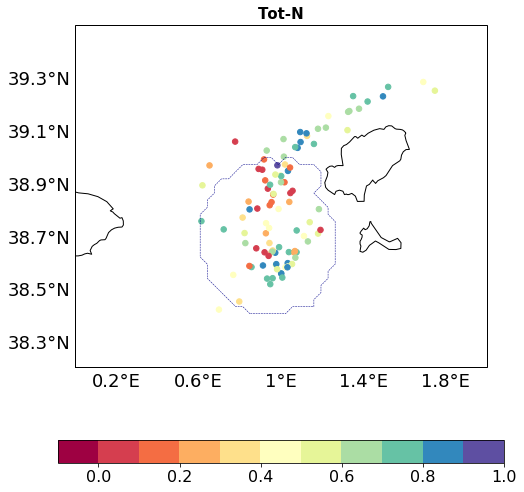

Skill Score = 0.5008569112979859


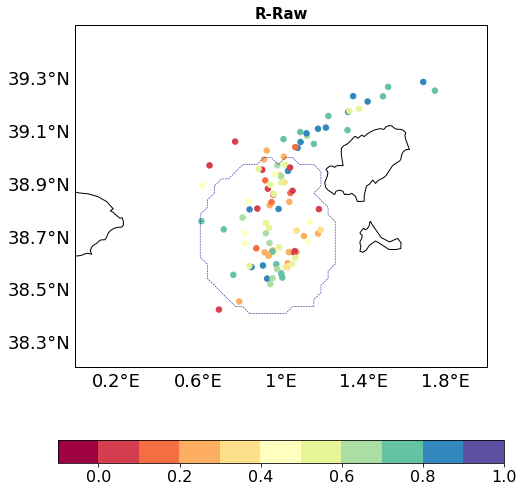

Skill Score = 0.4845713272603145


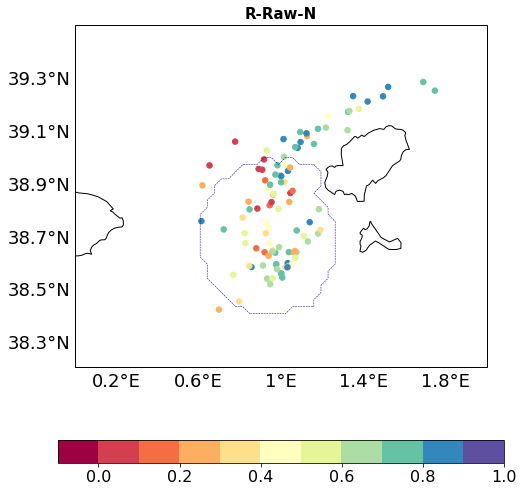

Skill Score = 0.5292182452053639


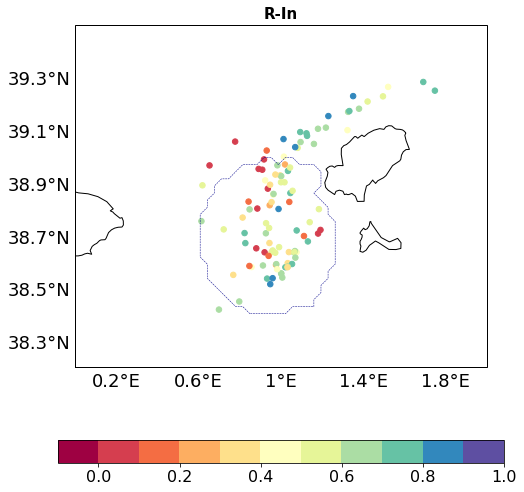

Skill Score = 0.5049918577965158


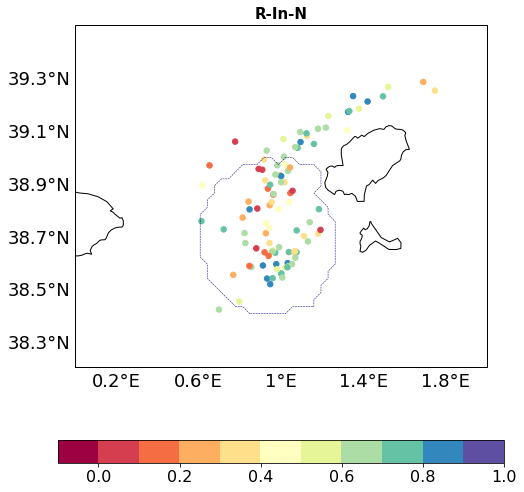

Skill Score = 0.5175006224912695


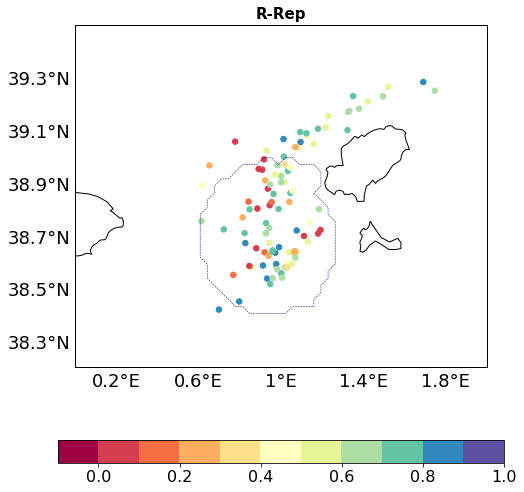

Skill Score = 0.5284278056355858


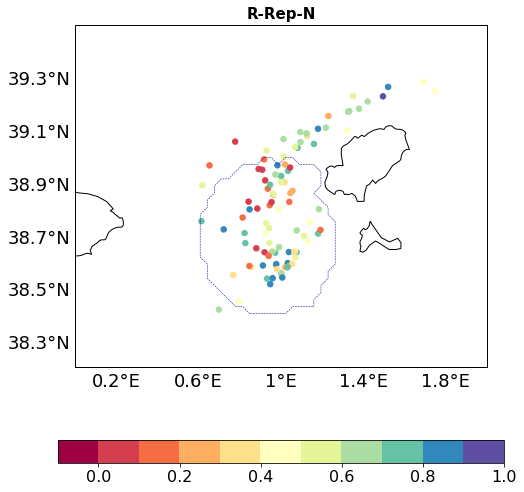

Skill Score = 0.49588498245167884


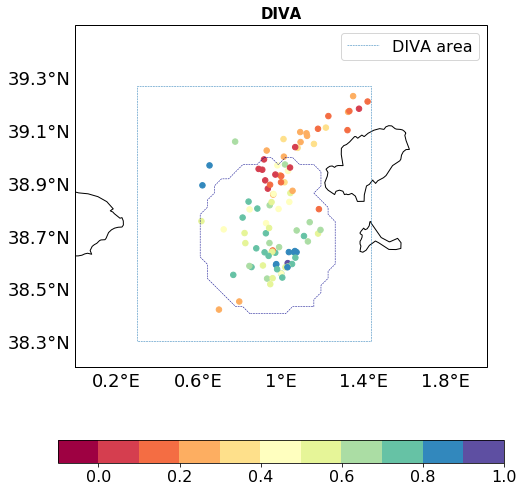

Skill Score = 0.47341899631444356


In [145]:
from pylab import *
import matplotlib.ticker as mticker

x = lon_cont
y = lat_cont

cmap = cm.get_cmap('Spectral',11)
for i, exp in enumerate(exp_list):

    fig = plt.figure(figsize=(8,9))

    ax, gl = tools.make_map(continents=False, limits=[0,2,38.2,39.5])
    if exp == 'DIVA':
        plt. scatter(lon0[point_in_diva==1], lat0[point_in_diva==1], 30, ss[exp].T[point_in_diva==1], transform=gl.crs, cmap=cmap, vmin=-0.1, vmax =1)
        plt.plot([lonmax_hfr, lonmax_hfr, lonmin_hfr, lonmin_hfr, lonmax_hfr], 
         [latmin_hfr, latmax_hfr, latmax_hfr, latmin_hfr, latmin_hfr],
         transform=gl.crs, linewidth=0.5, linestyle='--', label='DIVA area')
        plt.legend()
    else:
        plt. scatter(lon0, lat0, 30, ss[exp].T, transform=gl.crs, cmap=cmap, vmin=-0.1, vmax =1)
    plt.title(exp, fontsize=15, fontweight='bold')

    plt.colorbar(orientation='horizontal')
    
    plt.plot(x, y, 'darkblue', transform=gl.crs, linewidth=0.5, linestyle='--')
    
    gl.xlocator = mticker.FixedLocator([0.2, 0.6, 1.0, 1.4, 1.8])
    gl.ylocator = mticker.FixedLocator([38.3, 38.50, 38.7,38.9, 39.1, 39.3])
    
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 18}
    gl.ylabel_style = {'size': 18}

    plt.show()
    
    print('Skill Score = ' + str(np.nanmean(ss[exp].T)) )
    
    #fig.savefig('/home/jhernandez/public_html/OSE/Seminario/Liu_metric/liu_metric_map_{0}_{1}.png'.format(kd, exp), dpi=250)
    fig.savefig(F"/home/jhernandez/public_html/OSE/Code_v8_results/skill_score_maps/liu_metric_map_{kd}h_{exp}.png", dpi=250)

### Check fields DIVA

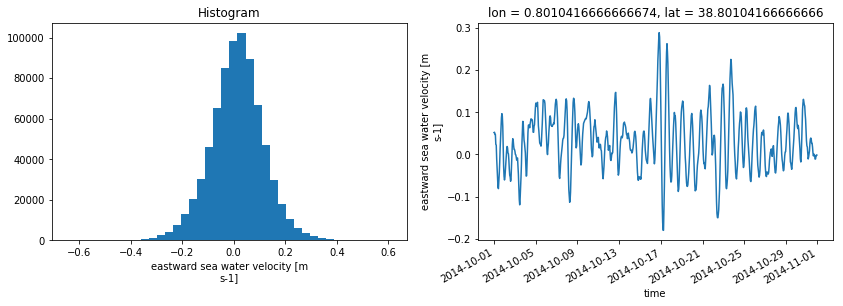

In [40]:
for var in ['u', 'v']:
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    ds_hfr[var].plot(bins=40)
    plt.subplot(122)
    ds_hfr[var][:,15,15].plot()
    plt.show()
    


In [45]:
df_ss0 = pd.DataFrame.from_dict(ss0, orient='index', columns= ['SS total', 'SS In', 'SS Out'])
df_ss1 = pd.DataFrame.from_dict(ss_diva_compare, orient='index', columns= ['SS Out', 'SS In-DIVA'])
df_ss = df_ss0.reset_index().merge(df_ss1, how='left').set_index('index')

df_ss

SS total     SS In    SS Out  SS In-DIVA
index                                            
CR       0.209760  0.141980  0.398040    0.429445
DIVA     0.471365  0.528330  0.293348    0.304452
GNR      0.335191  0.242015  0.594010    0.567256
GNR-N    0.390603  0.332381  0.552329    0.516102
Tot      0.486773  0.448768  0.592343    0.596119
Tot-N    0.448844  0.405964  0.567953    0.554558
R-Raw    0.437923  0.381877  0.593604    0.556855
R-Raw-N  0.466864  0.427475  0.576281    0.543627
R-In     0.472735  0.435886  0.575094    0.563765
R-In-N   0.459893  0.427168  0.550796    0.566890
R-Rep    0.488246  0.458766  0.570134    0.549287
R-Rep-N  0.451434  0.427596  0.517651    0.494757

In [48]:
df_ss.loc[['CR', 'DIVA']]

SS total    SS In    SS Out  SS In-DIVA
index                                         
CR     0.209760  0.14198  0.398040    0.429445
DIVA   0.471365  0.52833  0.293348    0.304452

In [51]:
df_ss['SS In'] / df_ss['SS In']['DIVA']

index
CR         0.268733
DIVA       1.000000
GNR        0.458076
GNR-N      0.629117
Tot        0.849409
Tot-N      0.768391
R-Raw      0.722800
R-Raw-N    0.809105
R-In       0.825026
R-In-N     0.808525
R-Rep      0.868332
R-Rep-N    0.809336
Name: SS In, dtype: float64

In [93]:
df_ss.to_excel('/home/jhernandez/public_html/OSE/Code_v8_results/skill_score_by_areas.xls')

In [33]:
experiment_list = {'CR': ['HFR_NOASSIM_Oct2014', 'black', 'CR'], 
                   'DIVA': ['DIVAnd-fields_v2', 'fuchsia', 'DIVA'],
            'GNR': ['HFR_generic_nonudging_Oct2014_v2', 'dodgerblue', 'GNR'],
            'GNR-N': ['HFR_generic_nudging_Oct2014_v2', 'darkblue', 'GNR-N'],
            'Tot': ['HFR_all_nonudging_Oct2014_v3', 'olivedrab', 'Tot'],
          #  'Tot2': ['HFR_totals_nonudging_Oct2014', 'green', 'Tot2'],
            'Tot-N': ['HFR_totals_nudging_Oct2014', 'darkgreen', 'Tot-N'],
            'R-Raw': ['HFR_radials_raw_nonudging_Oct2014', 'salmon', 'R-Raw'],     
            'R-Raw-N': ['HFR_radials_raw_nudging_Oct2014', 'darkred', 'R-Raw-N'],     
            'R-In': ['HFR_radials_inside_nonudging_Oct2014', 'gold', 'R-In'],
            'R-In-N': ['HFR_radials_inside_nudging_Oct2014', 'goldenrod', 'R-In-N'],
            'R-Rep': ['HFR_radials_rep_nonudging_Oct2014', 'darkgrey', 'R-Rep'],
            'R-Rep-N': ['HFR_radials_rep_nudging_Oct2014', 'grey', 'R-Rep-N'],
            
            
           }

subset = [0,1,2,3,4,5,6,7,8,9,10,11]
exp_list, colors, labels = select_experiments(subset, experiment_list=experiment_list)


 Selected experiments: ['CR', 'DIVA', 'GNR', 'GNR-N', 'Tot', 'Tot-N', 'R-Raw', 'R-Raw-N', 'R-In', 'R-In-N', 'R-Rep', 'R-Rep-N']


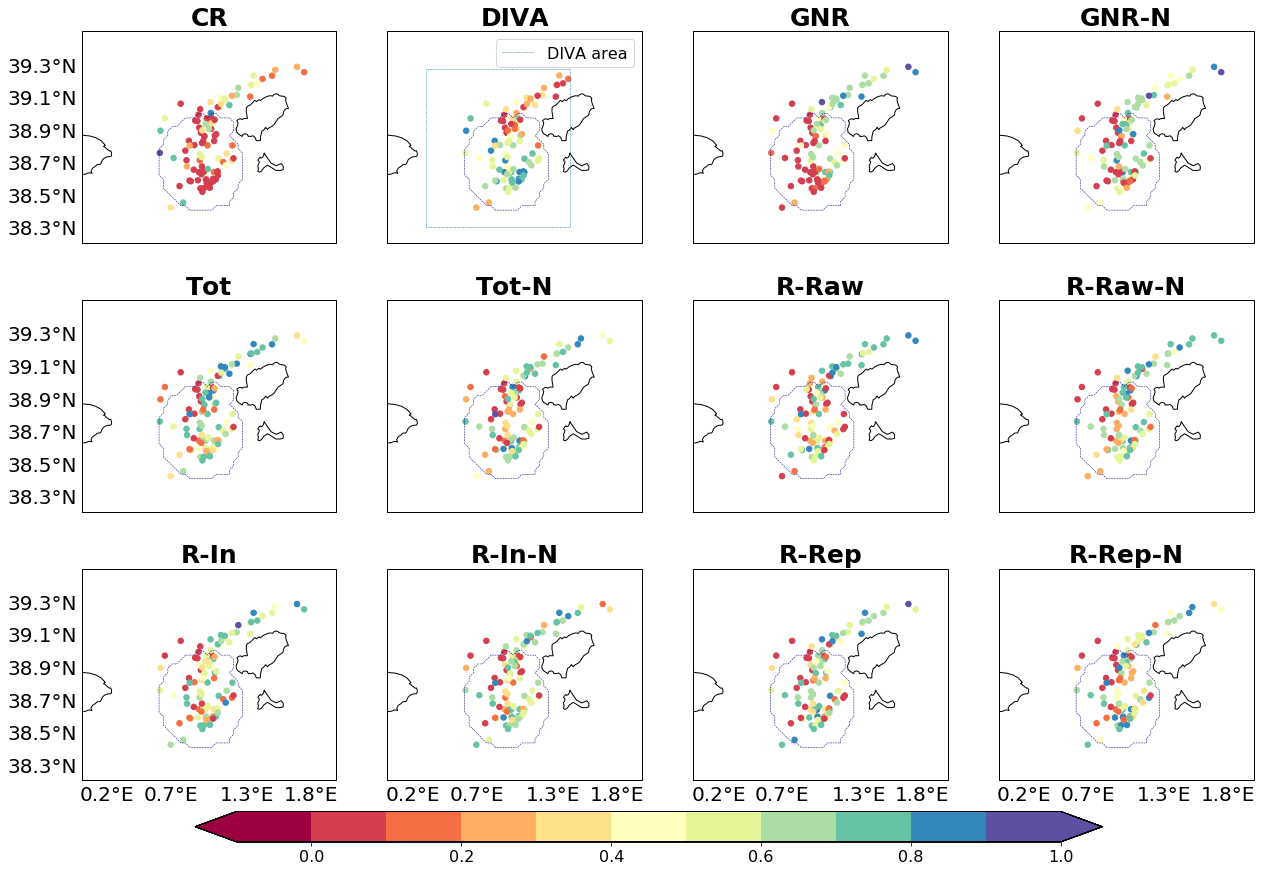

In [43]:
from pylab import *
import matplotlib.ticker as mticker

x = lon_cont
y = lat_cont


fig = plt.figure(figsize=(21,14))
cmap = cm.get_cmap('Spectral',11)
for i, exp in enumerate(exp_list):
    
    ax, gl = make_map(continents=False, subplot_dim=(3,4,i+1), limits=[0,2,38.2,39.5])
    if exp == 'DIVA':
        a = plt. scatter(lon0[point_in_diva==1], lat0[point_in_diva==1], 30, ss[exp].T[point_in_diva==1], transform=gl.crs, cmap=cmap, vmin=-0.1, vmax =1)
        plt.plot([lonmax_hfr, lonmax_hfr, lonmin_hfr, lonmin_hfr, lonmax_hfr], 
         [latmin_hfr, latmax_hfr, latmax_hfr, latmin_hfr, latmin_hfr],
         transform=gl.crs, linewidth=0.5, linestyle='--', label='DIVA area')
        plt.legend()
    else:
        a = plt. scatter(lon0, lat0, 30, ss[exp].T, transform=gl.crs, cmap=cmap, vmin=-0.1, vmax =1)
    plt.title(exp, fontsize=25, fontweight='bold')

    #plt.colorbar(orientation='horizontal')
    
    plt.plot(x, y, 'darkblue', transform=gl.crs, linewidth=0.5, linestyle='--')
    
    gl.xlocator = mticker.FixedLocator([0.2, 0.7, 1.3, 1.8])
    gl.ylocator = mticker.FixedLocator([38.3, 38.50, 38.7,38.9, 39.1, 39.3])
    
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}

    
    if i in [1,2,3,5,6,7,9,10,11]:
        gl.ylabels_left = False
    if i in [0,1,2,3,4,5,6,7]:
        gl.xlabels_bottom = False

    
    #plt.title(F"{experiments[i].replace('_',' ')} \n {strdate} ", fontweight='bold')
              
    
    #fig_raw_raw10.subplots_adjust(top=0.8)
    cbar_ax = fig.add_axes([0.20, 0.07, 0.60, 0.03])
    fig.colorbar(a, cax=cbar_ax, orientation='horizontal', extend='both')
    
plt.show()
    
#fig.savefig(F"/home/jhernandez/public_html/OSE/Code_v8_results/skill_score_maps/liu_metric_map_{kd}h_{exp}.png", dpi=250)

In [44]:
fig.savefig(F"/home/jhernandez/public_html/OSE/Code_v8_results/skill_score_maps/liu_metric_map_{kd}h_all.png", dpi=250)

In [61]:
exp_list[0:-2]

['CR', 'GNR', 'Tot', 'R-Raw', 'R-In', 'R-Rep', 'DIVA']

In [ ]:
from pylab import *
import matplotlib.ticker as mticker

x = lon_cont
y = lat_cont


fig = plt.figure(figsize=(21,14))
cmap = cm.get_cmap('Spectral',11)
for i, exp in enumerate(exp_list):
    
    ax, gl = make_map(continents=False, subplot_dim=(3,4,i+1), limits=[0,2,38.2,39.5])
    if exp == 'DIVA':
        a = plt. scatter(lon0[point_in_diva==1], lat0[point_in_diva==1], 30, ss[exp].T[point_in_diva==1], transform=gl.crs, cmap=cmap, vmin=-0.1, vmax =1)
        plt.plot([lonmax_hfr, lonmax_hfr, lonmin_hfr, lonmin_hfr, lonmax_hfr], 
         [latmin_hfr, latmax_hfr, latmax_hfr, latmin_hfr, latmin_hfr],
         transform=gl.crs, linewidth=0.5, linestyle='--', label='DIVA area')
        plt.legend()
    else:
        a = plt. scatter(lon0, lat0, 30, ss[exp].T, transform=gl.crs, cmap=cmap, vmin=-0.1, vmax =1)
    plt.title(exp, fontsize=25, fontweight='bold')

    #plt.colorbar(orientation='horizontal')
    
    plt.plot(x, y, 'darkblue', transform=gl.crs, linewidth=0.5, linestyle='--')
    
    gl.xlocator = mticker.FixedLocator([0.2, 0.7, 1.3, 1.8])
    gl.ylocator = mticker.FixedLocator([38.3, 38.50, 38.7,38.9, 39.1, 39.3])
    
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 20}
    gl.ylabel_style = {'size': 20}

    
    if i in [1,2,3,5,6,7,9,10,11]:
        gl.ylabels_left = False
    if i in [0,1,2,3,4,5,6,7]:
        gl.xlabels_bottom = False

    
    #plt.title(F"{experiments[i].replace('_',' ')} \n {strdate} ", fontweight='bold')
              
    
    #fig_raw_raw10.subplots_adjust(top=0.8)
    cbar_ax = fig.add_axes([0.20, 0.07, 0.60, 0.03])
    fig.colorbar(a, cax=cbar_ax, orientation='horizontal', extend='both')
    
plt.show()
    
#fig.savefig(F"/home/jhernandez/public_html/OSE/Code_v8_results/skill_score_maps/liu_metric_map_{kd}h_{exp}.png", dpi=250)